In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import colors

In [204]:
def absLoss(true:tf.Tensor,pred:tf.Tensor):
    #print(true)
    #print(pred)
    #set up a loss function beased on absolute value, gradient is sign of pred-true
    trueProto = tf.make_tensor_proto(true)
    predProto = tf.make_tensor_proto(pred)
    trueValues = tf.make_ndarray(trueProto)
    predictedValues =  tf.make_ndarray(predProto)
    #print(predictedValues)
    #print(trueValues)

    predictedValues = np.reshape(predictedValues,trueValues.shape)
    #trueValues = np.reshape(trueValues,predictedValues.shape)

    loss = predictedValues-trueValues
    #print(loss)
    #print()
    
    #gradient = np.zeros(loss.shape)
    gradient = 2*loss
    loss = loss**2

    loss_tensor = tf.convert_to_tensor(loss,dtype='float32')
    gradient_tensor = tf.convert_to_tensor(gradient,dtype='float32')

    return loss_tensor,gradient_tensor

size = 2
v1 = tf.convert_to_tensor(np.random.normal(0,1,size=(size,1)))
v2 = tf.convert_to_tensor(np.random.normal(0,1,size=(size)))

print(v1)
print()
print(v2)
print()
l,g = absLoss(v1,v2)
print(l)
print()
print(g)

tf.Tensor(
[[ 0.78984289]
 [-1.06833359]], shape=(2, 1), dtype=float64)

tf.Tensor([2.09966074 1.48118916], shape=(2,), dtype=float64)

tf.Tensor(
[[1.7156228]
 [6.5000663]], shape=(2, 1), dtype=float32)

tf.Tensor(
[[2.6196358]
 [5.0990453]], shape=(2, 1), dtype=float32)


In [241]:
#define model
def BuildModel(degree):
    Input_x = tf.keras.layers.Input(shape=(degree),name="x")

    denseLayer = tf.keras.layers.Dense(degree)(Input_x)
    denseLayer = tf.keras.layers.Dense(degree)(denseLayer)
    denseLayer = tf.keras.layers.Dense(degree)(denseLayer)
    denseLayer = tf.keras.layers.Dense(degree)(denseLayer)
    outputLayer = tf.keras.layers.Dense(1)(denseLayer)
    
    return tf.keras.Model(inputs= Input_x,outputs=outputLayer)

class Model_m9(tf.keras.Model):
    def __init__(self,degree):
        super(Model_m9, self).__init__()
        self.model = BuildModel(degree)

    def call(self,data,training = False):
        return self.model(data)

In [5]:
#function for trainin on
# f(x) = sin(x) * e**x

def f(x,noise:float=0):
    return np.add(np.add(np.sin(1.5*np.pi*x-0.5), np.exp(x)), np.random.normal(0,noise,size=x.shape))

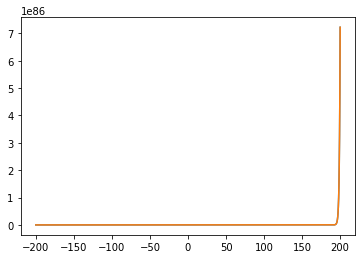

In [235]:
minVal = -200
maxVal = 200


x = np.linspace(minVal,maxVal,num=1000)
y1 = f(x,.1)
y2 = f(x)

plt.plot(x,y1)
plt.plot(x,y2)

In [247]:
PolyDegree = 0
numPoints = 10000
x_forModel = np.random.uniform(minVal,maxVal,size=numPoints)#np.polynomial.polynomial.polyvander(np.random.uniform(minVal,maxVal,size=numPoints),PolyDegree)
y_forModel = x_forModel.copy()#f(x_forModel[:,1],noise=.1)
print(x_forModel.shape)

(10000,)


In [244]:
model = Model_m9(PolyDegree+1)#add one for the constant
model.compile()#, loss= CustomTensorFlowLoss())
print(model.model.summary())
print()
print(model.trainable_weights)
lossArray = []


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 dense_28 (Dense)            (None, 1)                 2         
                                                                 
 dense_29 (Dense)            (None, 1)                 2         
                                                                 
 dense_30 (Dense)            (None, 1)                 2         
                                                                 
 dense_31 (Dense)            (None, 1)                 2         
                                                                 
 dense_32 (Dense)            (None, 1)                 2         
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params

In [246]:

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.00001,decay_steps=100000,decay_rate=0.86,staircase=True)
#lr_schedule = 0.000001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [229]:
print(x_forModel[0])
print(f(x_forModel[0]))


1.239710728509328
2.6463569006790904


In [169]:

y_pred = model.model(np.reshape(x_forModel[0,:],(1,PolyDegree+1)), training=True)
print(y_pred)

tf.Tensor([[2.565999]], shape=(1, 1), dtype=float32)


In [230]:
@tf.custom_gradient
def loss_fn(y_true,y_pred):
    lossVal, gradVal = absLoss(y_true,y_pred)
    lossVal = tf.reshape(lossVal,shape=(1,1))
    gradVal = tf.reshape(gradVal,shape=(1,1))
    #print("lossval and grad=",lossVal,gradVal)
    def grad(upstream):
        #print("\tGradient parameters:\n",upstream)
        pred_grad = upstream * gradVal
        #var_grad = upstream * tf.constant(1)
        #print("\tPredGrad = ",pred_grad)
        return pred_grad,upstream
    
    #print("lossVal = ",lossVal)
    return lossVal, grad


@tf.custom_gradient
def foo_custom_grad(x):
    y = np.square(x)
    def grad_fn(dy):
        grad = 2 * np.array(x)
        return grad * dy
    return y, grad_fn

@tf.custom_gradient
def custom_operation(x, y):
    print("custom operation:",x,y)
    # define the gradient
    def grad(g):
        
        print("\tcustomGrad:",g)
        return g, g
    
    forward_pass = x * y
    print("Forward pass:",forward_pass)

    return forward_pass, grad

In [248]:
epochs = 100 
batchSize = numPoints//epochs
lossOfAllTrainings = []
#loss_fn = CustomTensorFlowLoss()
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    batchLoss = []
    for batchNum in range(batchSize):
        dataPoint_x = np.reshape(x_forModel[epoch*batchSize + batchNum],(1,PolyDegree+1))
        dataPoint_y = y_forModel[epoch*batchSize + batchNum]

        #print(dataPoint_x)
        #print(dataPoint_y)

        # Iterate over the batches of the dataset.

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape(persistent=True) as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            y_pred = model.model(dataPoint_x, training=True)  # Logits for this minibatch
            
            #with tape.stop_recording(): 
            #print("\nypred:",y_pred)
            loss_value = loss_fn(dataPoint_y,y_pred)
            batchLoss.append(float(np.mean(loss_value)))
            lossOfAllTrainings.append(batchLoss[-1])
            #loss_value = custom_operation(y_forModel,y_pred)
            #loss_value = foo_custom_grad(y_pred)
            #print("\nabs loss:",loss_value)
            #loss_value = tf.keras.losses.MSE(y_forModel,y_pred)
                
            #print("\nmseLoss:",loss_value)
            #print(loss_gradient)

        #layerGrad = tape.gradient(loss_value,y_pred,unconnected_gradients='zero')
        #layerGrad_var = tf.Variable(layerGrad)
        #layerGrad_var.assign(loss_gradient)
        #layerGrad[0] = loss_gradient
        #print(layerGrad_var)
        #print(layerGrad)
        
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        #grads = tape.gradient(loss_value, model.trainable_weights)#,output_gradients=loss_gradient,unconnected_gradients='zero')
        grads = tape.gradient(loss_value, model.trainable_weights,unconnected_gradients='zero')
        #print()
        #print("\nGradients:",grads)
        #print()
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        #print(model.trainable_weights)

    # Log every 200 batches.
    lossArray.append(float(np.mean(batchLoss)))
    print(
        "Training loss at epoch %d: %.4f"
        % (epoch, lossArray[-1])
    )  
    
    #print("Seen so far: %s samples" % ((step + 1) * batch_size))
del tape


Start of epoch 0
Training loss at epoch 0: 30279.7805

Start of epoch 1
Training loss at epoch 1: 30888.8699

Start of epoch 2
Training loss at epoch 2: 29458.9227

Start of epoch 3
Training loss at epoch 3: 32945.3838

Start of epoch 4
Training loss at epoch 4: 30267.0711

Start of epoch 5
Training loss at epoch 5: 33870.9380

Start of epoch 6
Training loss at epoch 6: 28600.8641

Start of epoch 7
Training loss at epoch 7: 27359.6729

Start of epoch 8
Training loss at epoch 8: 26584.7632

Start of epoch 9
Training loss at epoch 9: 35449.1254

Start of epoch 10
Training loss at epoch 10: 30587.3018

Start of epoch 11
Training loss at epoch 11: 30691.2498

Start of epoch 12
Training loss at epoch 12: 30616.4985

Start of epoch 13
Training loss at epoch 13: 31373.7088

Start of epoch 14
Training loss at epoch 14: 25365.0988

Start of epoch 15
Training loss at epoch 15: 27787.8835

Start of epoch 16
Training loss at epoch 16: 29030.3443

Start of epoch 17
Training loss at epoch 17: 24617

In [234]:
print(model.trainable_weights)

[<tf.Variable 'dense_24/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.1537347]], dtype=float32)>, <tf.Variable 'dense_24/bias:0' shape=(1,) dtype=float32, numpy=array([-0.10002164], dtype=float32)>, <tf.Variable 'dense_25/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.568524]], dtype=float32)>, <tf.Variable 'dense_25/bias:0' shape=(1,) dtype=float32, numpy=array([-0.0999915], dtype=float32)>]


In [ ]:
hist = model.fit(x_forModel,y_forModel,
                 epochs=1,
                 validation_split=.1,
                 shuffle=True)

In [ ]:
def plotHistory(hist):
    fig,ax = plt.subplots(1,1)
    ax.set_title("")
    keys = hist.history.keys()
    y = np.arange(1,hist.params['epochs']+1)
    for key in keys:
        if('output' in key):
            minVal = min(hist.history[key])
            meanVal = np.mean(hist.history[key])
            maxVal = max(hist.history[key])
            if(minVal != maxVal):
                print("{}:\n\tmin:{}\n\tmean:{}\n\tmax:{}".format(key,minVal,meanVal,maxVal))
                #ax.plot(y,hist.history[key],linewidth=0.5,label=key)
        else:
            ax.plot(y,hist.history[key],label=key)
            minVal = min(hist.history[key])
            meanVal = np.mean(hist.history[key])
            maxVal = max(hist.history[key])
            print("{}:\n\tmin:{}\n\tmean:{}\n\tmax:{}".format(key,minVal,meanVal,maxVal))
    
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()

In [ ]:
plotHistory(hist)

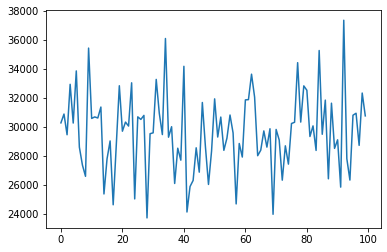

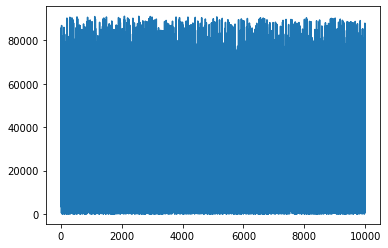

In [249]:
plt.plot(np.arange(len(lossArray)),lossArray)
plt.show()
plt.plot(np.arange(len(lossOfAllTrainings)),lossOfAllTrainings)
plt.show()

32/32 [==============================] - 0s 1ms/step
(1000, 1)


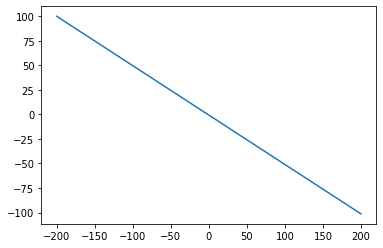

In [251]:
#visualizeOutputs

y_pred = model.predict(x)#np.polynomial.polynomial.polyvander(x,PolyDegree))
print(y_pred.shape)
plt.plot(x,y_pred)